In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00a 0:00:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15832, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 15832 (delta 22), reused 10 (delta 10), pack-reused 15788 (from 4)
Receiving objects: 100% (15832/15832), 6.41 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (11524/11524), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't mat

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [4]:
register_coco_instances("my_dataset_train", {}, "/kaggle/input/coco-dataset-3/dataset/train/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/coco-dataset-3/dataset/test/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/test")

In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[12/27 10:09:21 d2.data.datasets.coco]: Loaded 2298 images in COCO format from /kaggle/input/coco-dataset-3/dataset/train/_annotations.coco.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/27 10:09:24 d2.data.datasets.coco]: Loaded 216 images in COCO format from /kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json


In [7]:
test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[12/27 10:09:25 d2.data.datasets.coco]: Loaded 72 images in COCO format from /kaggle/input/coco-dataset-3/dataset/test/_annotations.coco.json


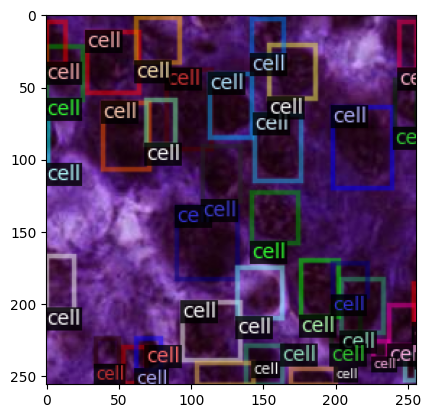

In [8]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 5000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 class (cell)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[12/27 10:27:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
trainer.train() #Start the training process

[12/27 10:27:30 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/27 10:27:40 d2.utils.events]:  eta: 0:37:26  iter: 19  total_loss: 4.401  loss_cls: 0.7006  loss_box_reg: 0.547  loss_rpn_cls: 2.997  loss_rpn_loc: 0.1905    time: 0.4512  last_time: 0.4702  data_time: 0.0125  last_data_time: 0.0055   lr: 4.9953e-06  max_mem: 2850M
[12/27 10:27:49 d2.utils.events]:  eta: 0:39:12  iter: 39  total_loss: 2.681  loss_cls: 0.679  loss_box_reg: 0.6533  loss_rpn_cls: 1.208  loss_rpn_loc: 0.1919    time: 0.4661  last_time: 0.4584  data_time: 0.0055  last_data_time: 0.0053   lr: 9.9902e-06  max_mem: 2850M
[12/27 10:27:59 d2.utils.events]:  eta: 0:39:02  iter: 59  total_loss: 1.962  loss_cls: 0.6236  loss_box_reg: 0.7201  loss_rpn_cls: 0.4975  loss_rpn_loc: 0.1586    time: 0.4683  last_time: 0.5394  data_time: 0.0052  last_data_time: 0.0053   lr: 1.4985e-05  max_mem: 2850M
[12/27 10:28:09 d2.utils.events]:  eta: 0:38:53  iter: 79  total_loss: 1.775  loss_cls: 0.5908  loss_box_reg: 0.6707  loss_rpn_cls: 0.3813  loss_rpn_loc: 0.1966    time: 0.4723  last_time:

In [17]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/kaggle/working/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [18]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/27 11:09:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/models/Detectron2_Models/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

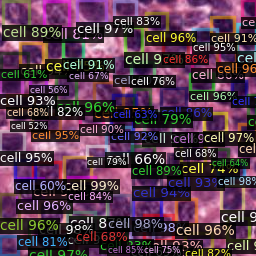

In [20]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1
    )
    out = v.draw_instance_predictions(instances)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/27 11:09:55 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/27 11:09:55 d2.data.datasets.coco]: Loaded 216 images in COCO format from /kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json
[12/27 11:09:55 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 14803        |
|            |              |
[12/27 11:09:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 11:09:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 11:09:55 d2.data.common]: Serializing 216 elements to byte tensors and concatenating them all ...
[12/27 11:09:55 d2.data.common]: Serialized dataset takes 0.48 MiB
[12/27 11:09:55 d2.evaluation.evaluator]: Start inference on 216 batches

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/27 11:09:57 d2.evaluation.evaluator]: Inference done 11/216. Dataloading: 0.0014 s/iter. Inference: 0.1088 s/iter. Eval: 0.0004 s/iter. Total: 0.1106 s/iter. ETA=0:00:22
[12/27 11:10:02 d2.evaluation.evaluator]: Inference done 57/216. Dataloading: 0.0016 s/iter. Inference: 0.1087 s/iter. Eval: 0.0004 s/iter. Total: 0.1108 s/iter. ETA=0:00:17
[12/27 11:10:07 d2.evaluation.evaluator]: Inference done 102/216. Dataloading: 0.0017 s/iter. Inference: 0.1088 s/iter. Eval: 0.0004 s/iter. Total: 0.1109 s/iter. ETA=0:00:12
[12/27 11:10:12 d2.evaluation.evaluator]: Inference done 147/216. Dataloading: 0.0017 s/iter. Inference: 0.1092 s/iter. Eval: 0.0003 s/iter. Total: 0.1113 s/iter. ETA=0:00:07
[12/27 11:10:17 d2.evaluation.evaluator]: Inference done 192/216. Dataloading: 0.0017 s/iter. Inference: 0.1097 s/iter. Eval: 0.0003 s/iter. Total: 0.1118 s/iter. ETA=0:00:02
[12/27 11:10:20 d2.evaluation.evaluator]: Total inference time: 0:00:23.684850 (0.112250 s / iter per device, on 1 devices)
[12

(256, 256, 3)
{'instances': Instances(num_instances=76, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[7.4445e+01, 7.7613e+01, 8.6023e+01, 9.0365e+01],
        [1.0142e+02, 1.6291e+02, 1.1550e+02, 1.7587e+02],
        [3.7271e+01, 7.1057e+01, 5.4219e+01, 9.2199e+01],
        [1.8073e+02, 8.7751e+01, 1.9311e+02, 1.0013e+02],
        [1.0369e+02, 1.5917e+01, 1.1765e+02, 2.9300e+01],
        [1.6377e+02, 1.0714e+02, 1.7598e+02, 1.1817e+02],
        [2.2088e+02, 1.2376e+02, 2.3208e+02, 1.3650e+02],
        [1.9703e+02, 1.1057e+02, 2.0763e+02, 1.2441e+02],
        [5.8105e+01, 1.8725e+02, 7.3076e+01, 1.9946e+02],
        [8.7786e+01, 9.2193e+01, 1.0146e+02, 1.0311e+02],
        [4.5502e+01, 1.3189e+02, 5.8592e+01, 1.4217e+02],
        [1.9492e+02, 1.2847e+02, 2.0623e+02, 1.3885e+02],
        [2.1562e+02, 7.7282e+01, 2.2933e+02, 8.7489e+01],
        [6.0723e+01, 1.5752e+02, 7.2568e+01, 1.6809e+02],
        [2.1057e+02, 1.3382e+02, 2.2116e+02, 1.4564e+02],
        [3.12

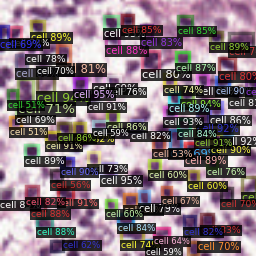

In [24]:
# Test with new image
new_im = cv2.imread("/kaggle/input/custom-dataset/selected_patches/patch_patient_004_node_4_x_10304_y_18272.png")
new_im = cv2.resize(new_im, (256, 256))
print(new_im.shape)

outputs = predictor(new_im)
instances = outputs["instances"].to("cpu")

print(outputs)

confidence_threshold = 0.5
instances = instances[instances.scores > confidence_threshold]

v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata, scale=1)
out = v.draw_instance_predictions(instances)

cv2_imshow(out.get_image()[:, :, ::-1])

# TODO

- Extracting cells number and density
- Create csv metadata file containing this infos
- Feature extraction 

In [ ]:
"""
# Directory path to the input images folder
input_images_directory = "/kaggle/input/camelyon/dataset/patches"

# Output directory where the segmented images will be saved
output_directory = "/kaggle/working/test_results/masks"  # Replace this with the path to your desired output directory
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
def process_images_in_directory(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png')): 
                image_path = os.path.join(root, file)
                new_im = cv2.imread(image_path)

                # Perform prediction on the new image
                outputs = predictor(new_im)  # Replace `predictor` with your initialized model

                # Use Visualizer to draw the predictions on the image
                v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

                # Create the output path, maintaining the folder structure
                relative_path = os.path.relpath(image_path, input_dir)
                result_path = os.path.join(output_dir, os.path.splitext(relative_path)[0] + "_result.png")
                os.makedirs(os.path.dirname(result_path), exist_ok=True)

                # Save the segmented image
                cv2.imwrite(result_path, out.get_image()[:, :, ::-1])
                print(f"Image at {image_path} processed")

# Process all images in the directory
process_images_in_directory(input_images_directory, output_directory)

print("Segmentation of all images in subfolders completed.")
"""

In [25]:
import csv
import os
import time
import re
import cv2
import numpy as np

# Directory path to the input images folder
input_images_directory = "/kaggle/input/custom-dataset/selected_patches"

# Output directory where the CSV file will be saved
output_csv_path = "/kaggle/working/test_results/output_objects.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Gather all image paths
image_paths = []
for root, _, files in os.walk(input_images_directory):
    for file in files:
        if file.endswith('.png'):  # Process only PNG files
            image_paths.append(os.path.join(root, file))

# Function to extract patient, node, x, and y coordinates from file name
def parse_filename(file_name):
    pattern = r"patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+)"
    match = re.search(pattern, file_name)
    if match:
        return match.group(1), match.group(2), match.group(3), match.group(4)
    return None, None, None, None

# Total number of images
total_images = len(image_paths)
print(f"Total Images: {total_images}")

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["patient", "node", "x_coord", "y_coord", "bounding_box", "area", "number_of_cells", "cell_density"])

    start_time = time.time()  # Record the start time of the entire process

    # Loop over the images
    for idx, image_path in enumerate(image_paths):
        image_start_time = time.time()  # Start time for the current image
        image = cv2.imread(image_path)

        file_name = os.path.basename(image_path)
        patient, node, x_coord, y_coord = parse_filename(file_name)

        # Perform prediction on the image
        outputs = predictor(image)  # Replace `predictor` with your initialized model

        # Extract bounding boxes and scores
        pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

        # Calculate total area covered by all bounding boxes
        total_area = 0
        for box in pred_boxes:
            box_area = (box[2] - box[0]) * (box[3] - box[1])
            total_area += box_area

        # Number of detected cells
        num_cells = len(pred_boxes)

        # Calculate cell density (number of cells per unit area)
        cell_density = num_cells / total_area if total_area > 0 else 0

        # Write information for each detected object
        for bounding_box in pred_boxes:
            area = (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1])  # Area of the bounding box

            # Write the object information to the CSV file
            csvwriter.writerow([
                patient, node, x_coord, y_coord, 
                bounding_box.tolist(),  # Convert NumPy array to list
                area, 
                num_cells, 
                cell_density
            ])

        # Calculate time taken for the current image
        image_time_taken = time.time() - image_start_time

        # Calculate estimated remaining time
        images_processed = idx + 1
        elapsed_time = time.time() - start_time
        avg_time_per_image = elapsed_time / images_processed
        remaining_time = avg_time_per_image * (total_images - images_processed)

        # Print progress
        print(f"Processed {images_processed}/{total_images} images. "
              f"Time for current image: {image_time_taken:.2f}s. "
              f"Estimated time remaining: {remaining_time:.2f}s.")

print("Object-level information saved to CSV file.")

Total Images: 1000
Processed 1/1000 images. Time for current image: 0.18s. Estimated time remaining: 179.86s.
Processed 2/1000 images. Time for current image: 0.13s. Estimated time remaining: 156.44s.
Processed 3/1000 images. Time for current image: 0.12s. Estimated time remaining: 143.57s.
Processed 4/1000 images. Time for current image: 0.12s. Estimated time remaining: 136.95s.
Processed 5/1000 images. Time for current image: 0.12s. Estimated time remaining: 132.77s.
Processed 6/1000 images. Time for current image: 0.12s. Estimated time remaining: 130.30s.
Processed 7/1000 images. Time for current image: 0.12s. Estimated time remaining: 128.29s.
Processed 8/1000 images. Time for current image: 0.12s. Estimated time remaining: 126.91s.
Processed 9/1000 images. Time for current image: 0.12s. Estimated time remaining: 125.60s.
Processed 10/1000 images. Time for current image: 0.12s. Estimated time remaining: 124.48s.
Processed 11/1000 images. Time for current image: 0.12s. Estimated tim

<a href="/kaggle/working/models/Detectron2_Models/model_final.pth"> Download File </a>

In [1]:
import os
print(os.listdir('/kaggle/working/models/Detectron2_Models'))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/models/Detectron2_Models'